In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import joblib
import random


import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

import tensorflow as tf
from tensorflow.keras import layers, models

In [2]:
IMG_SIZE = (128, 128)
IMAGE_DIR = r"/Users/matthewcaro/CSE4095_Project/Scratch/Data/spectrograms"
CSV_PATH = r"/Users/matthewcaro/CSE4095_Project/Scratch/Data/features.csv"

In [3]:
def load_hybrid_data(image_dir, csv_path):
    df = pd.read_csv(csv_path)
    X_images, X_features, y_labels = [], [], []
    filenames = df['filename'].tolist()

    for _, row in df.iterrows():
        genre = row['label']
        # Convert 'blues.00000.wav' → 'blues00000.png'
        fname = row['filename'].replace('.wav', '.png')
        img_path = os.path.join(image_dir, genre, fname)

        if not os.path.exists(img_path):
            print(f"[SKIP] Missing image for {fname}")
            continue

        img = cv2.imread(img_path)
        img = cv2.resize(img, IMG_SIZE)
        img = img / 255.0
        X_images.append(img)

        feature_vector = row.drop(['filename', 'label']).values.astype(np.float32)
        X_features.append(feature_vector)
        y_labels.append(genre)

    return np.array(X_images), np.array(X_features), np.array(y_labels), np.array(filenames)

In [4]:
X_img, X_feat, y_raw, filenames = load_hybrid_data(IMAGE_DIR, CSV_PATH)

scaler = StandardScaler()
X_feat_scaled = scaler.fit_transform(X_feat)

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y_raw)

X_img_train, X_img_val, X_feat_train, X_feat_val, y_train, y_val, filenames_train, filenames_val = train_test_split(
    X_img, X_feat_scaled, y_encoded, filenames, test_size=0.2, stratify=y_encoded, random_state=42
)

In [5]:
def build_hybrid_model(image_shape, feature_dim, num_classes):
    img_input = layers.Input(shape=image_shape)

    x = layers.Conv2D(32, (3, 3), activation='relu')(img_input)
    x = layers.MaxPooling2D((2, 2))(x)

    x = layers.Conv2D(64, (3, 3), activation='relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)

    x = layers.Conv2D(128, (3, 3), activation='relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)

    x = layers.Conv2D(256, (3, 3), activation='relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)

    x = layers.Conv2D(512, (3, 3), activation='relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)

    x = layers.GlobalAveragePooling2D()(x)

    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dropout(0.5)(x)

    feat_input = layers.Input(shape=(feature_dim,))
    y = layers.Dense(256, activation='relu')(feat_input)
    y = layers.Dense(128, activation='relu')(y)
    y = layers.Dropout(0.5)(y)

    combined = layers.Concatenate()([x, y])

    z = layers.Dense(256, activation='relu')(combined)
    z = layers.Dropout(0.5)(z)
    output = layers.Dense(num_classes, activation='softmax')(z)

    model = models.Model(inputs=[img_input, feat_input], outputs=output)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model


In [6]:
model = build_hybrid_model((128, 128, 3), X_feat.shape[1], len(label_encoder.classes_))
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 126, 126,  │        896 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 63, 63,    │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 61, 61,    │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 30, 30,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 28, 28,    │     73,856 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 14, 14,    │          0 │ conv2d_2[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 12, 12,    │    295,168 │ max_pooling2d_2[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 6, 6, 256) │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 4, 4, 512) │  1,180,160 │ max_pooling2d_3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 2, 2, 512) │          0 │ conv2d_4[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 58)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 512)       │          0 │ max_pooling2d_4[… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 256)       │     15,104 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 512)       │    262,656 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 128)       │     32,896 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 512)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 128)       │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 640)       │          0 │ dropout[0][0],  

 Total params: 2,045,898 (7.80 MB)

 Trainable params: 2,045,898 (7.80 MB)

 Non-trainable params: 0 (0.00 B)

In [7]:
history = model.fit(
    [X_img_train, X_feat_train], y_train,
    validation_data=([X_img_val, X_feat_val], y_val),
    epochs=40,
    batch_size=32
)

Epoch 1/40
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 98ms/step - accuracy: 0.1975 - loss: 2.2132 - val_accuracy: 0.4500 - val_loss: 1.7352
Epoch 2/40
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 96ms/step - accuracy: 0.4259 - loss: 1.6946 - val_accuracy: 0.5400 - val_loss: 1.3460
Epoch 3/40
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 108ms/step - accuracy: 0.5474 - loss: 1.3326 - val_accuracy: 0.6250 - val_loss: 1.1855
Epoch 4/40
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - accuracy: 0.5672 - loss: 1.2318 - val_accuracy: 0.6650 - val_loss: 1.0511
Epoch 5/40
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step - accuracy: 0.6191 - loss: 1.0408 - val_accuracy: 0.7150 - val_loss: 0.9887
Epoch 6/40
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - accuracy: 0.6763 - loss: 0.9532 - val_accuracy: 0.7100 - val_loss: 0.9439
Epoch 7/40
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - accuracy: 0.6910 - loss: 0.8774 - val_accuracy: 0.7200 - val_loss: 0.9081
Epoch 8/40
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step - accuracy: 0.7421 - loss: 0.7266 - val_accuracy: 0.7150 - 

In [8]:
model.save("hybrid_model.keras")
joblib.dump(scaler, "scaler.pkl")
joblib.dump(label_encoder, "label_encoder.pkl")

['label_encoder.pkl']

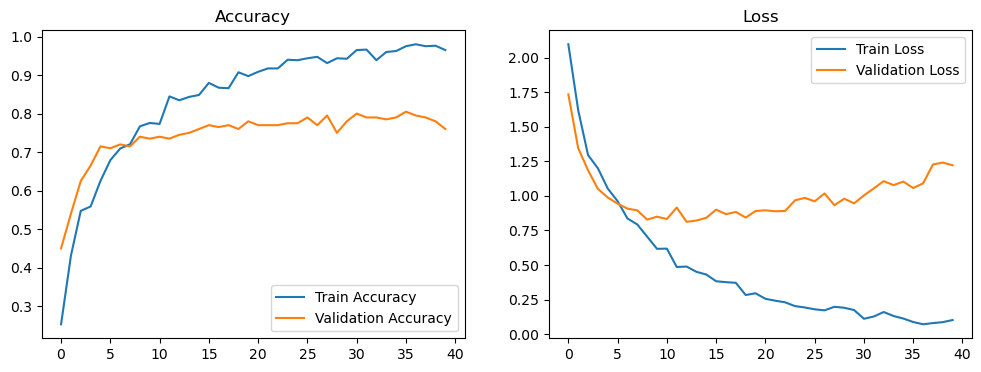

In [9]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.legend()
plt.title("Accuracy")

plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.title("Loss")

plt.show()

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


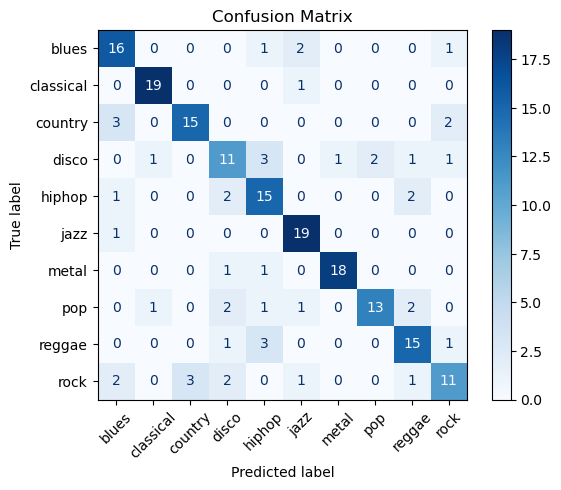

In [10]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred = model.predict([X_img_val, X_feat_val])
y_pred_labels = np.argmax(y_pred, axis=1)

cm = confusion_matrix(y_val, y_pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(xticks_rotation=45, cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

In [11]:
from sklearn.metrics import classification_report

print(classification_report(y_val, y_pred_labels, target_names=label_encoder.classes_))


              precision    recall  f1-score   support

       blues       0.70      0.80      0.74        20
   classical       0.90      0.95      0.93        20
     country       0.83      0.75      0.79        20
       disco       0.58      0.55      0.56        20
      hiphop       0.62      0.75      0.68        20
        jazz       0.79      0.95      0.86        20
       metal       0.95      0.90      0.92        20
         pop       0.87      0.65      0.74        20
      reggae       0.71      0.75      0.73        20
        rock       0.69      0.55      0.61        20

    accuracy                           0.76       200
   macro avg       0.76      0.76      0.76       200
weighted avg       0.76      0.76      0.76       200



In [12]:
import numpy as np
import matplotlib.pyplot as plt

def predict_sample_from_validation(model, X_val_img, X_val_feat, y_val, label_encoder=None, idx=0, show_image=True):
    sample_img = np.expand_dims(X_val_img[idx], axis=0)
    sample_feat = np.expand_dims(X_val_feat[idx], axis=0)
    true_label = y_val[idx]

    prediction = model.predict([sample_img, sample_feat], verbose=0)
    predicted_class = np.argmax(prediction)

    if label_encoder:
        pred_label = label_encoder.inverse_transform([predicted_class])[0]
        true_label_text = label_encoder.inverse_transform([true_label])[0]
    else:
        pred_label = predicted_class
        true_label_text = true_label

    print(f"Predicted Genre: {pred_label}")
    print(f"Actual Genre:    {true_label_text}")

    if show_image:
        plt.imshow(X_val_img[idx])
        plt.title(f"Spectrogram (True: {true_label_text})")
        plt.axis("off")
        plt.show()

In [13]:
def test_random_samples(model, X_val_img, X_val_feat, y_val, filenames_val, label_encoder=None, num_samples=10):
    indices = random.sample(range(len(y_val)), num_samples)
    print(f"Testing {num_samples}\n")

    for i, idx in enumerate(indices, 1):
        print(f"Sample {i}:")
        print(f"Filename: {filenames_val[idx]}")

        # Predict
        pred = model.predict([np.expand_dims(X_val_img[idx], axis=0), np.expand_dims(X_val_feat[idx], axis=0)], verbose=0)
        pred_class = np.argmax(pred, axis=1)[0]
        pred_label = label_encoder.inverse_transform([pred_class])[0]

        # Actual
        actual_class = y_val[idx]
        actual_label = label_encoder.inverse_transform([actual_class])[0]  # ✅ FIXED: decode integer back to genre text

        print(f"Predicted Genre: {pred_label}")
        print(f"Actual Genre:    {actual_label}")

        # Show spectrogram
        plt.imshow(X_val_img[idx])
        plt.title(f"Spectrogram (True: {actual_label})")
        plt.axis('off')
        plt.show()
        print("-" * 50)


Testing 10

Sample 1:
Filename: rock.00074.wav
Predicted Genre: rock
Actual Genre:    rock


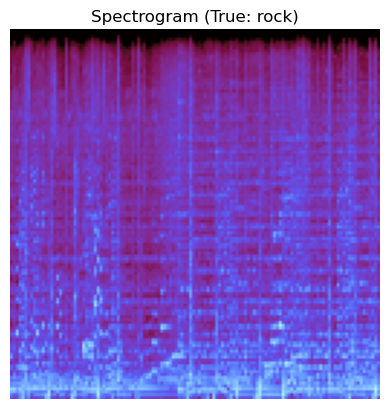

--------------------------------------------------
Sample 2:
Filename: disco.00085.wav
Predicted Genre: disco
Actual Genre:    disco


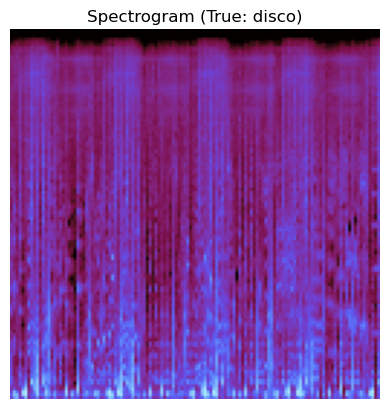

--------------------------------------------------
Sample 3:
Filename: rock.00069.wav
Predicted Genre: rock
Actual Genre:    rock


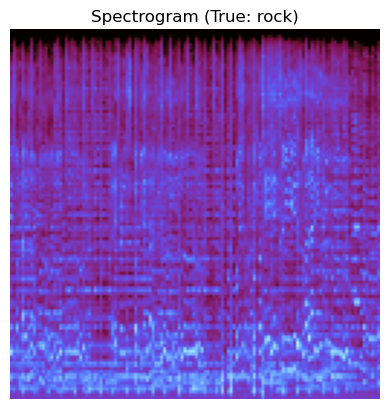

--------------------------------------------------
Sample 4:
Filename: blues.00023.wav
Predicted Genre: jazz
Actual Genre:    blues


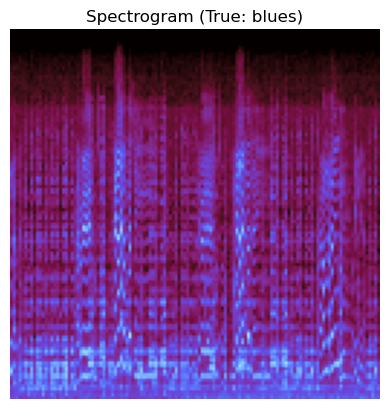

--------------------------------------------------
Sample 5:
Filename: hiphop.00061.wav
Predicted Genre: reggae
Actual Genre:    hiphop


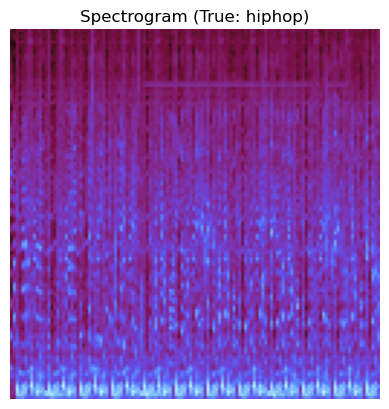

--------------------------------------------------
Sample 6:
Filename: disco.00047.wav
Predicted Genre: classical
Actual Genre:    disco


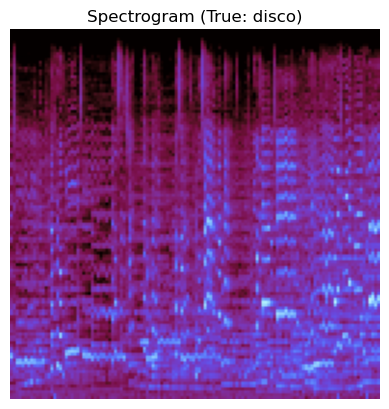

--------------------------------------------------
Sample 7:
Filename: pop.00096.wav
Predicted Genre: pop
Actual Genre:    pop


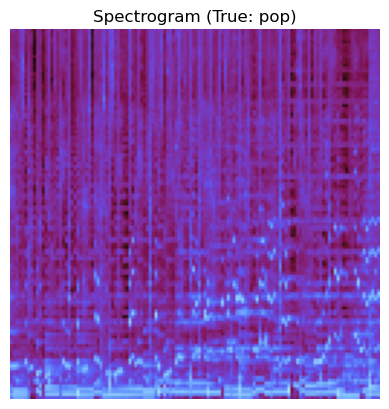

--------------------------------------------------
Sample 8:
Filename: pop.00064.wav
Predicted Genre: disco
Actual Genre:    pop


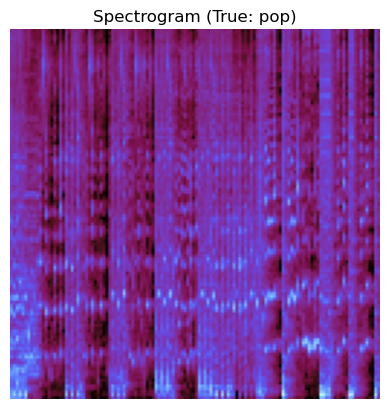

--------------------------------------------------
Sample 9:
Filename: jazz.00088.wav


KeyboardInterrupt: 

In [25]:
test_random_samples(model, X_img_val, X_feat_val, y_val, filenames_val, label_encoder=label_encoder, num_samples=10)